<a href="https://colab.research.google.com/github/ghosh-sarbajit/AboutNLP/blob/main/Multilinear_Perceptron_for_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[Citation](https://web.stanford.edu/class/cs224n/)**

* ["Word Window Classification" tutorial notebook]((https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1204/materials/ww_classifier.ipynb) by Matt Lamm, from Winter 2020 offering of CS224N
* Official PyTorch Documentation on [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) by Soumith Chintala
* PyTorch Tutorial Notebook, [Build Basic Generative Adversarial Networks (GANs) | Coursera](https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans) by Sharon Zhou, offered on Coursera

* [PyTorch](https://pytorch.org/)
* [TensorFlow](https://www.tensorflow.org/)
* [Installation](https://pytorch.org/)

In [52]:
# Example of zip function of python
x = [1,2,3]
y = [4,5,6]
zipped = zip(x,y)
zipped_list=list(zipped)

print(x, "\t", y, "\t", *zipped)

print(x, "\t", y, "\t", zipped_list)

x1, y1 = zip(*zipped_list)

print(x1, "\t", y1)

[1, 2, 3] 	 [4, 5, 6] 	
[1, 2, 3] 	 [4, 5, 6] 	 [(1, 4), (2, 5), (3, 6)]
(1, 2, 3) 	 (4, 5, 6)


In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from functools import partial # Je kono function er structure niye onyo kaje babohar kore (fol mix er kaj thakle sobji mix kora jai)

import numpy as np

In [54]:
corpus = [
          "We always come to Paris",
          "The professor is from Australia",
          "I live in Stanford",
          "He comes from Taiwan",
          "The capital of Turkey is Ankara or Paris"
         ]

In [55]:
# The preprocessing function we will use to generate our training examples
# Our function is a simple one, we lowercase the letters
# and then tokenize the words.
def preprocess_sentence(sentence):
  return sentence.lower().split()

# Create our training set
train_sentences = [preprocess_sentence(sent) for sent in corpus]
print(train_sentences)

# Set of locations that appear in our corpus
locations = set(["australia", "ankara", "paris", "stanford", "taiwan", "turkey"])

# Our train labels
train_labels = [[1 if word in locations else 0 for word in sent] for sent in train_sentences]
print(train_labels)

# Find all the unique words in our corpus
vocabulary = set(w for s in train_sentences for w in s)

# add <unk> and <pad> tokens
vocabulary.add("<unk>")
vocabulary.add("<pad>")

ix_to_word = sorted(list(vocabulary))
word_to_ix = {word: ind for ind, word in enumerate(ix_to_word)}

[['we', 'always', 'come', 'to', 'paris'], ['the', 'professor', 'is', 'from', 'australia'], ['i', 'live', 'in', 'stanford'], ['he', 'comes', 'from', 'taiwan'], ['the', 'capital', 'of', 'turkey', 'is', 'ankara', 'or', 'paris']]
[[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1, 0, 1, 0, 1]]


In [56]:
def custom_collate_fn(batch, window_size, word_to_ix):
  # Let training examples (x) and labels (y)
  # Break our batch into the training examples (x) and labels (y)
  # We are turning our x and y into tensors because nn.utils.rnn.pad_sequence method expects tensors.
  # This is also useful since our model will be expecting tensor inputs.
  x, y = zip(*batch)

  # Now we need to window pad our training examples.
  # We have already defined a function to handle window padding.
  # We are including it here again so that everything is in one place.
  def pad_window(sentence, window_size, pad_token="<pad>"):
    window = [pad_token] * window_size
    return window + sentence + window

  # Pad the train examples.
  x = [pad_window(s, window_size=window_size) for s in x]

  # Now we need to turn words in our training examples to indices.
  # We are copying the function defined earlier for the same reason as above.
  def convert_tokens_to_indices(sentence, word_to_ix):
    return [word_to_ix.get(token, word_to_ix["<unk>"]) for token in sentence]

  # Convert the train examples into indices.
  x = [convert_tokens_to_indices(s, word_to_ix) for s in x]

  # We will now pad the examples so that the lengths of all the example in one batch are the same, making it possible to do matrix operations.
  # We set the batch_first parameter to True so that the returned matrix has the batch as the first dimension.
  pad_token_ix = word_to_ix["<pad>"]

  # pad_sequence function expects the input to be a tensor, so we turn x into one
  x = [torch.LongTensor(x_i) for x_i in x]
  x_padded = nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=pad_token_ix)

  # We will also pad the labels.
  # Before doing so, we will record the number of labels so that we know how many words existed in each example.
  lengths = [len(label) for label in y]
  lenghts = torch.LongTensor(lengths)

  y = [torch.LongTensor(y_i) for y_i in y]
  y_padded = nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=0)

  # We are now ready to return our variables. The order we return our variables
  # here will match the order we read them in our training loop.
  return x_padded, y_padded, lenghts

In [57]:
# # Parameters to be passed to the DataLoader
# data = list(zip(train_sentences, train_labels))
# print(data, "\n")

# batch_size = 2
# shuffle = False
# window_size = 2

# collate_fn = partial(custom_collate_fn, window_size=window_size, word_to_ix=word_to_ix) # word_to_index
# print(collate_fn, "\n")

# # Instantiate the DataLoader
# loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

# print(loader, "\n")

# # Go through one loop
# counter = 0
# for batched_x, batched_y, batched_lengths in loader:
#   print(f"Iteration {counter}")
#   print("Batched Input:")
#   print(batched_x)
#   print("Batched Labels:")
#   print(batched_y)
#   print("Batched Lengths:")
#   print(batched_lengths)
#   print("")
#   counter += 1

# # corpus = [
# #           "We always come to Paris",
# #           "The professor is from Australia",
# #           "I live in Stanford",
# #           "He comes from Taiwan",
# #           "The capital of Turkey is Ankara or Paris"
# #          ]
# # [[23, 2, 6, 21, 16],
# #  [20, 17, 12, 8, 4],
# #  [10, 13, 11, 18],
# #  [9, 7, 8, 19],
# #  [20, 5, 14, 22, 12, 3, 15, 16]]

In [58]:
# Print the original tensor
print(f"Original Tensor: ")
print(batched_x)
print("")

# Create the 2 * 2 + 1 chunks
chunk = batched_x.unfold(1, window_size*2 + 1, 1)
print(f"Windows: ")
print(chunk)

Original Tensor: 
tensor([[ 0,  0, 20,  5, 14, 22, 12,  3, 15, 16,  0,  0]])

Windows: 
tensor([[[ 0,  0, 20,  5, 14],
         [ 0, 20,  5, 14, 22],
         [20,  5, 14, 22, 12],
         [ 5, 14, 22, 12,  3],
         [14, 22, 12,  3, 15],
         [22, 12,  3, 15, 16],
         [12,  3, 15, 16,  0],
         [ 3, 15, 16,  0,  0]]])


In [59]:
class WordWindowClassifier(nn.Module):

  def __init__(self, hyperparameters, vocab_size, pad_ix=0):
    super(WordWindowClassifier, self).__init__()

    """ Instance variables """
    self.window_size = hyperparameters["window_size"]
    self.embed_dim = hyperparameters["embed_dim"]
    self.hidden_dim = hyperparameters["hidden_dim"]
    self.freeze_embeddings = hyperparameters["freeze_embeddings"]

    """ Embedding Layer
    Takes in a tensor containing embedding indices, and returns the
    corresponding embeddings. The output is of dim
    (number_of_indices * embedding_dim).

    If freeze_embeddings is True, set the embedding layer parameters to be
    non-trainable. This is useful if we only want the parameters other than the
    embeddings parameters to change.
    """

    self.embeds = nn.Embedding(vocab_size, self.embed_dim, padding_idx=pad_ix)
    if self.freeze_embeddings:
      self.embed_layer.weight.requires_grad = False

    """ Hidden Layer
    """
    full_window_size = 2 * window_size + 1
    self.hidden_layer = nn.Sequential(
      nn.Linear(full_window_size * self.embed_dim, self.hidden_dim),
      nn.Tanh()
    )

    """ Output Layer
    """
    self.output_layer = nn.Linear(self.hidden_dim, 1)

    """ Probabilities
    """
    self.probabilities = nn.Sigmoid()

  def forward(self, inputs):
    """
    Let B:= batch_size
        L:= window-padded sentence length
        D:= self.embed_dim
        S:= self.window_size
        H:= self.hidden_dim

    inputs: a (B, L) tensor of token indices
    """
    B, L = inputs.size()

    """
    Reshaping.
    Takes in a (B, L) LongTensor
    Outputs a (B, L~, S) LongTensor
    """
    # Fist, get our word windows for each word in our input.
    token_windows = inputs.unfold(1, 2 * self.window_size + 1, 1)
    _, adjusted_length, _ = token_windows.size()

    # Good idea to do internal tensor-size sanity checks, at the least in comments!
    assert token_windows.size() == (B, adjusted_length, 2 * self.window_size + 1)

    """
    Embedding.
    Takes in a torch.LongTensor of size (B, L~, S)
    Outputs a (B, L~, S, D) FloatTensor.
    """
    embedded_windows = self.embeds(token_windows)

    """
    Reshaping.
    Takes in a (B, L~, S, D) FloatTensor.
    Resizes it into a (B, L~, S*D) FloatTensor.
    -1 argument "infers" what the last dimension should be based on leftover axes.
    """
    embedded_windows = embedded_windows.view(B, adjusted_length, -1)

    """
    Layer 1.
    Takes in a (B, L~, S*D) FloatTensor.
    Resizes it into a (B, L~, H) FloatTensor
    """
    layer_1 = self.hidden_layer(embedded_windows)

    """
    Layer 2
    Takes in a (B, L~, H) FloatTensor.
    Resizes it into a (B, L~, 1) FloatTensor.
    """
    output = self.output_layer(layer_1)

    """
    Softmax.
    Takes in a (B, L~, 1) FloatTensor of unnormalized class scores.
    Outputs a (B, L~, 1) FloatTensor of (log-)normalized class scores.
    """
    output = self.probabilities(output)
    output = output.view(B, -1)

    return output

In [60]:
# Prepare the data
data = list(zip(train_sentences, train_labels))
batch_size = 2
shuffle = True
window_size = 2
collate_fn = partial(custom_collate_fn, window_size=window_size, word_to_ix=word_to_ix)

# Instantiate a DataLoader
loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

# Initialize a model
# It is useful to put all the model hyperparameters in a dictionary
model_hyperparameters = {
    "batch_size": 4,
    "window_size": 2,
    "embed_dim": 25,
    "hidden_dim": 25,
    "freeze_embeddings": False,
}

vocab_size = len(word_to_ix)
print(vocab_size)
model = WordWindowClassifier(model_hyperparameters, vocab_size)

# Define an optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Define a loss function, which computes to binary cross entropy loss
def loss_function(batch_outputs, batch_labels, batch_lengths):
    # Calculate the loss for the whole batch
    bceloss = nn.BCELoss() # Binary Cross Entropy Loss
    loss = bceloss(batch_outputs, batch_labels.float())

    # Rescale the loss. Remember that we have used lengths to store the
    # number of words in each training example
    loss = loss / batch_lengths.sum().float()

    return loss

24


In [61]:
# Function that will be called in every epoch
def train_epoch(loss_function, optimizer, model, loader):

  # Keep track of the total loss for the batch
  total_loss = 0
  for batch_inputs, batch_labels, batch_lengths in loader:
    # Clear the gradients
    optimizer.zero_grad()
    # Run a forward pass
    outputs = model.forward(batch_inputs)
    # Compute the batch loss
    loss = loss_function(outputs, batch_labels, batch_lengths)
    # Calculate the gradients
    loss.backward()
    # Update the parameteres
    optimizer.step()
    total_loss += loss.item()

  return total_loss, outputs


# Function containing our main training loop
def train(loss_function, optimizer, model, loader, num_epochs=10000):

  # Iterate through each epoch and call our train_epoch function
  for epoch in range(num_epochs):
    epoch_loss, outputs = train_epoch(loss_function, optimizer, model, loader)
    if epoch % 100 == 0: print(epoch_loss)

  return outputs

In [62]:
num_epochs = 1000
outputs = train(loss_function, optimizer, model, loader, num_epochs=num_epochs)

0.3094598799943924
0.22039741650223732
0.17901499196887016
0.16151771321892738
0.13384608551859856
0.09432131797075272
0.0811755508184433
0.08625388890504837
0.06662532407790422
0.05556576885282993


In [63]:
print(outputs)

tensor([[0.0352, 0.0710, 0.0435, 0.0698, 0.8912]], grad_fn=<ViewBackward0>)


In [64]:
!pip install torchviz
from IPython.display import clear_output
clear_output()

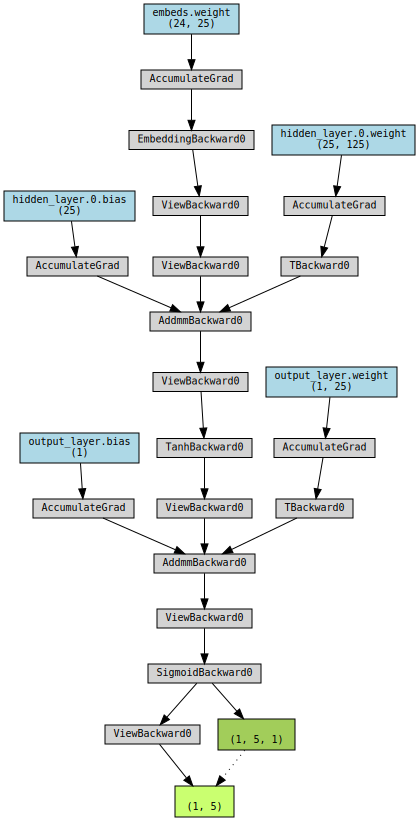

In [65]:
from torchviz import make_dot
from IPython.display import Image, SVG, display

dot = make_dot(outputs, params=dict(model.named_parameters()))
dot.format = 'svg'
# dot.render('WordWindowClassifier')
dot.render("word_window_classifier")
# display(Image("WordWindowClassifier.jpg"))
display(SVG("word_window_classifier.svg"))

In [66]:
# Create test sentences
test_corpus = ["She went to Borojaguli via helabottola"]
test_sentences = [s.lower().split() for s in test_corpus]
test_labels = [[0, 0, 0, 1, 0, 1]]

# Create a test loader
test_data = list(zip(test_sentences, test_labels))
batch_size = 1
shuffle = False
window_size = 2
collate_fn = partial(custom_collate_fn, window_size=2, word_to_ix=word_to_ix)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=1,
                                           shuffle=False,
                                           collate_fn=collate_fn)

In [67]:
for test_instance, labels, _ in test_loader:
  outputs = model.forward(test_instance)
  print(labels)
  print(outputs)

tensor([[0, 0, 0, 1, 0, 1]])
tensor([[0.3102, 0.5142, 0.5196, 0.3851, 0.7883, 0.5400]],
       grad_fn=<ViewBackward0>)
